# Toronto House Price Prediction

In [1]:
# import dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import session
from sqlalchemy import create_engine, func
import seaborn as sns # visualization


### Download dataset, explore and clean dataset

In [2]:
df_prices = pd.read_csv('https://raw.githubusercontent.com/zuwulin/final_project/ari_branch/Finalized_Data_for_SQL/GTA_houses_TABLEAU.csv')
df_prices.to_csv('GTA_houses_TABLEAU.csv')

In [3]:
# Check the dimension of the dataset
df_prices.shape

(1851, 8)

In [4]:
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1851 entries, 0 to 1850
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Full_Address  1851 non-null   object 
 1   Bedrooms      1851 non-null   int64  
 2   Bathrooms     1851 non-null   int64  
 3   Price         1851 non-null   int64  
 4   City          1851 non-null   object 
 5   Home_Type     1851 non-null   object 
 6   Latitude      1851 non-null   float64
 7   Longitude     1851 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 115.8+ KB


In [5]:
df_prices.head()

,Full_Address,Bedrooms,Bathrooms,Price,City,Home_Type,Latitude,Longitude
0,"6225 Lawrence Ave E, Toronto, ON M1C 5G4",3,4,799900,Toronto,SINGLE_FAMILY,43.655720,-79.457450
1,"3840 Bathurst St #702, Toronto, ON M3H 6C6",2,2,699000,Toronto,CONDO,43.623860,-79.488945
2,"8 Littleleaf Dr, Toronto, ON M1B 1Z1",3,3,1149900,Toronto,CONDO,43.723150,-79.448230
3,"2301 Danforth Ave #306, Toronto, ON M4C 0A7",2,2,699000,Toronto,CONDO,43.642390,-79.424736
4,"16 Catalda Ct, Toronto, ON M2R 3X5",4,5,2690000,Toronto,CONDO,43.641495,-79.410070


In [6]:
df_prices.tail()

,Full_Address,Bedrooms,Bathrooms,Price,City,Home_Type,Latitude,Longitude
1846,"173 Sassafras Cir, Vaughan, ON L4J 8M6",3,4,7998000,Vaughan,SINGLE_FAMILY,43.84832,-79.623740
1847,"9075 Jane St #1904, Vaughan, ON L6A 4H9",2,2,10500000,Vaughan,CONDO,43.79403,-79.446880
1848,"62 Glen Abbey Trl, Vaughan, ON L4H 3X7",4,4,11750000,Vaughan,SINGLE_FAMILY,43.81835,-79.430730
1849,"15 N Park Rd #808, Vaughan, ON L4J 0A1",1,2,12998888,Vaughan,SINGLE_FAMILY,43.83860,-79.641716
1850,"196 Marlott Rd, Vaughan, ON L6A 1H2",4,5,13500000,Vaughan,SINGLE_FAMILY,43.86965,-79.705060


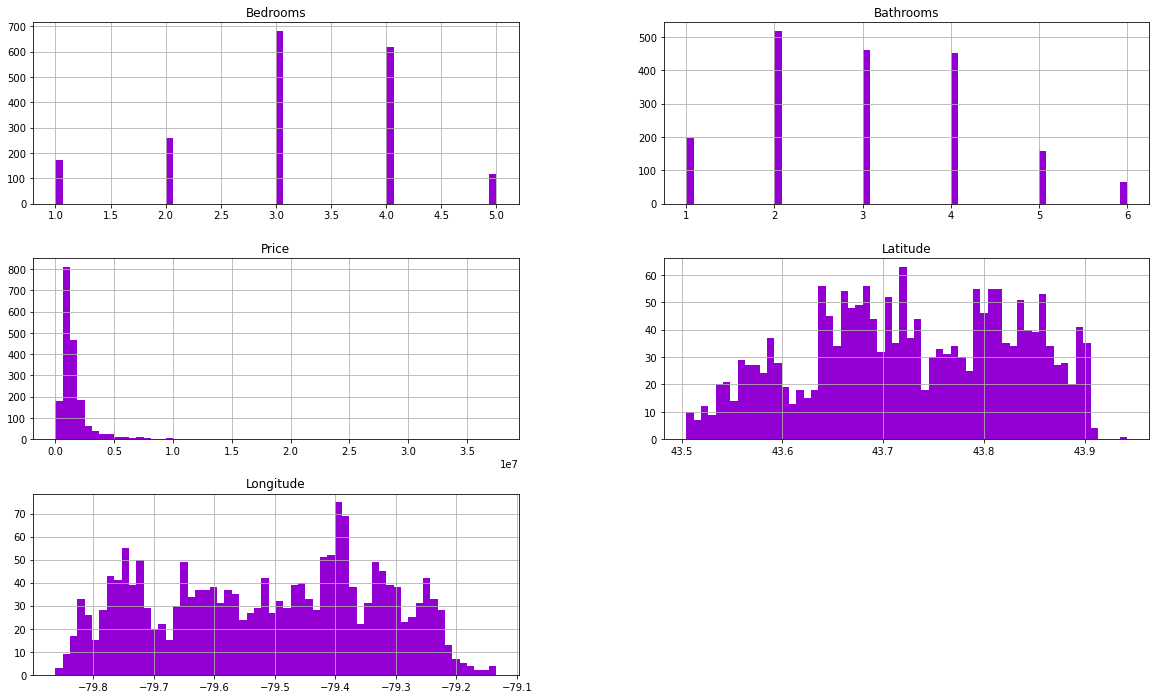

In [7]:
# EXPLORATORY DATA ANALYSIS
color1 = 'darkviolet'
color2 = 'indigo'
df_prices.hist(bins=60, figsize=(20,12),color=color1);plt.show()


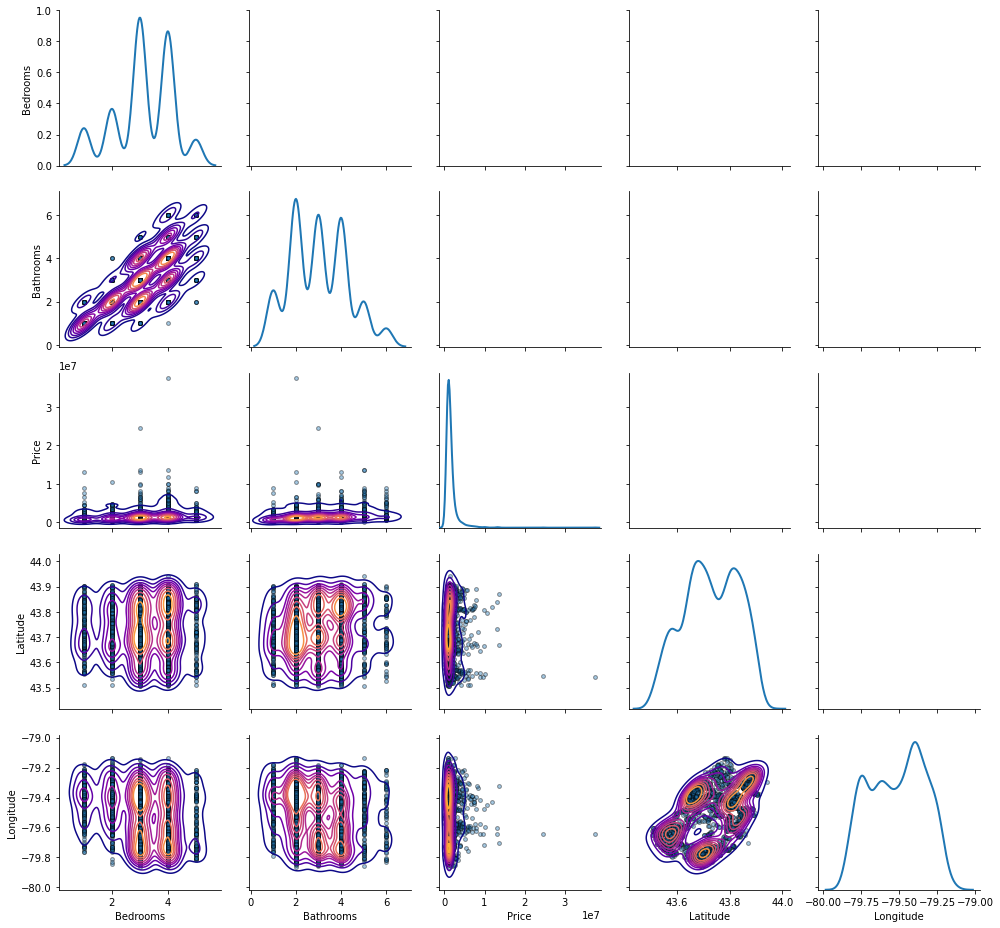

In [8]:

#''' Draw a Bivariate Seaborn Pairgrid /w KDE density w/ '''
def snsPairGrid(df_prices):

    ''' Plots a Seaborn Pairgrid w/ KDE & scatter plot of df features'''
    g = sns.PairGrid(df_prices,diag_sharey=False)
    g.fig.set_size_inches(14,13)
    g.map_diag(sns.kdeplot, lw=2) # draw kde approximation on the diagonal
    g.map_lower(sns.scatterplot,s=15,edgecolor="k",linewidth=1,alpha=0.4) # scattered plot on lower half
    g.map_lower(sns.kdeplot,cmap='plasma',n_levels=10) # kde approximation on lower half
    plt.tight_layout()

# Seaborn get a little slow, let's plot some interesting features

tlist = [ 'Bedrooms', 'Bathrooms', 'Price', 'Latitude', 'Longitude']
snsPairGrid(df_prices[tlist])

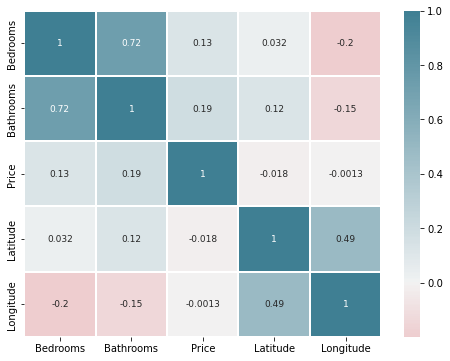

In [11]:
# Create features Heatmap to see how features are correlated with sale price

def correlantion_heatmap(df, center = None):
    fig, ax = plt.subplots(figsize = [8,6])
    colormap = sns.diverging_palette(10, 220, as_cmap=True)
    fig = sns.heatmap(df.corr(),
                cmap = colormap,
               center = center,
                annot = True,
                linewidths = 0.1,
                annot_kws={'fontsize':9})
    
    
correlantion_heatmap(df_prices, center=0)

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
# Creating dummy variables
gta_houses_dummies = pd.get_dummies(df_prices, columns=['City', 'Home_Type'])
gta_houses_dummies.head()

,Full_Address,Bedrooms,Bathrooms,Price,Latitude,Longitude,City_Brampton,City_Markham,City_Mississauga,City_Toronto,City_Vaughan,Home_Type_CONDO,Home_Type_SINGLE_FAMILY,Home_Type_TOWNHOUSE
0,"6225 Lawrence Ave E, Toronto, ON M1C 5G4",3,4,799900,43.655720,-79.457450,0,0,0,1,0,0,1,0
1,"3840 Bathurst St #702, Toronto, ON M3H 6C6",2,2,699000,43.623860,-79.488945,0,0,0,1,0,1,0,0
2,"8 Littleleaf Dr, Toronto, ON M1B 1Z1",3,3,1149900,43.723150,-79.448230,0,0,0,1,0,1,0,0
3,"2301 Danforth Ave #306, Toronto, ON M4C 0A7",2,2,699000,43.642390,-79.424736,0,0,0,1,0,1,0,0
4,"16 Catalda Ct, Toronto, ON M2R 3X5",4,5,2690000,43.641495,-79.410070,0,0,0,1,0,1,0,0


In [14]:
#save the gta_houses_cleaned_dummies df as a separate csv file
gta_houses_dummies.to_csv('GTA_houses_final.csv', index=False)

In [15]:
#identify the input and target variables
X = gta_houses_dummies.drop(['Price','Full_Address'], axis=1)

y = gta_houses_dummies[['Price']]

In [16]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 20, random_state = 2222)

# Train the Model
regr = RandomForestRegressor(n_estimators = 100, random_state = 2222, n_jobs = -1)
regr.fit(X_train, y_train.values.ravel())

RandomForestRegressor(n_jobs=-1, random_state=2222)

In [17]:
X_test

,Bedrooms,Bathrooms,Latitude,Longitude,City_Brampton,City_Markham,City_Mississauga,City_Toronto,City_Vaughan,Home_Type_CONDO,Home_Type_SINGLE_FAMILY,Home_Type_TOWNHOUSE
688,4,3,43.705524,-79.745580,1,0,0,0,0,0,1,0
776,3,1,43.720910,-79.704040,1,0,0,0,0,0,1,0
1513,4,4,43.570200,-79.695230,0,0,1,0,0,0,1,0
1826,2,2,43.871044,-79.481770,0,0,0,0,1,0,1,0
994,4,5,43.899460,-79.223040,0,1,0,0,0,0,1,0
624,4,5,43.680313,-79.729660,1,0,0,0,0,0,0,1
970,3,2,43.831066,-79.404594,0,1,0,0,0,0,0,1
21,3,2,43.707310,-79.465744,0,0,0,1,0,1,0,0
1443,3,3,43.524590,-79.700140,0,0,1,0,0,0,1,0
451,3,1,43.765762,-79.257965,0,0,0,1,0,0,1,0


In [18]:
# Make prediction
predictions = regr.predict(X_test)


result = X_test
result['price'] = y_test
result['prediction'] = predictions.tolist()
result['prediction'] = result['prediction'].astype('int')

result.head()

,Bedrooms,Bathrooms,Latitude,Longitude,City_Brampton,City_Markham,City_Mississauga,City_Toronto,City_Vaughan,Home_Type_CONDO,Home_Type_SINGLE_FAMILY,Home_Type_TOWNHOUSE,price,prediction
688,4,3,43.705524,-79.74558,1,0,0,0,0,0,1,0,949000,1045674
776,3,1,43.720910,-79.70404,1,0,0,0,0,0,1,0,1249000,949582
1513,4,4,43.570200,-79.69523,0,0,1,0,0,0,1,0,3149000,1765933
1826,2,2,43.871044,-79.48177,0,0,0,0,1,0,1,0,3288000,3185523
994,4,5,43.899460,-79.22304,0,1,0,0,0,0,1,0,995000,1382031


In [19]:
# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R2 Score
r2 = r2_score(y_test.values.ravel(), predictions)

# Mean Absolute Error
mae = mean_absolute_error(y_test.values.ravel(), predictions)

#Print Results
print("Mean squared error (MSE): ", round(mse, 2))
print("R2 Score: ", round(r2, 2))
print("Mean Absolute Error (MAE): ", round(mae, 2))

Mean squared error (MSE):  259125079933.5
R2 Score:  0.62
Mean Absolute Error (MAE):  364387.3


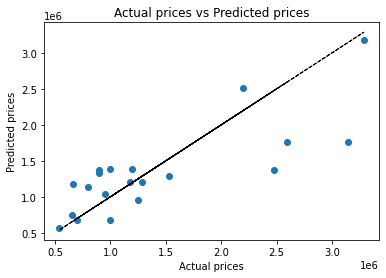

In [20]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_test, predictions)
plt.plot(y_test, y_test,'k--',lw=1)
plt.xlabel("Actual prices")
plt.ylabel("Predicted prices")
plt.title("Actual prices vs Predicted prices")
plt.show()

In [21]:
X_test.shape

(20, 14)

In [22]:
X_train.shape

(1831, 12)

In [23]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 688 to 26
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Bedrooms                 20 non-null     int64  
 1   Bathrooms                20 non-null     int64  
 2   Latitude                 20 non-null     float64
 3   Longitude                20 non-null     float64
 4   City_Brampton            20 non-null     uint8  
 5   City_Markham             20 non-null     uint8  
 6   City_Mississauga         20 non-null     uint8  
 7   City_Toronto             20 non-null     uint8  
 8   City_Vaughan             20 non-null     uint8  
 9   Home_Type_CONDO          20 non-null     uint8  
 10  Home_Type_SINGLE_FAMILY  20 non-null     uint8  
 11  Home_Type_TOWNHOUSE      20 non-null     uint8  
 12  price                    20 non-null     int64  
 13  prediction               20 non-null     int32  
dtypes: float64(2), int32(1), i

In [24]:
result.to_csv('prediction_price.csv')